## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
# read csv file
df = pd.read_csv("ab_data.csv")

# get the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [6]:
# cols and rows information
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [7]:
# get unique user ids
df.user_id.nunique()

290584

d. The proportion of users converted.

In [8]:
# get proportion of converted users
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [11]:
#Compute a simple cross-tabulation of two columns 
pd.crosstab(df.group, df.landing_page, margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


In [15]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [16]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [19]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [20]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [22]:
# get unique user ids
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [25]:
# get the duplicated id
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [27]:
# get the information of the duplicated id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [33]:
# drop one of duplicated id
df2 = df2.drop_duplicates(['user_id'])

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [34]:
# get the converting probability
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [130]:
# get the control group converting probability
cont_prob = df2[df2['group'] == 'control']['converted'].mean()
cont_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [131]:
# get the treatment group converting probability
treat_prob = df2[df2['group'] == 'treatment']['converted'].mean()
treat_prob

0.11880806551510564

d. What is the probability that an individual received the new page?

In [46]:
# get the probability of receiveing a new page
df2['landing_page'].value_counts()[0] / len(df2)

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
I do not see strong evidence that the new treatment page leads to more conversions, due to that:
1. Since the probability of an individual converting is 0.12 after rounding and the probability that an individual in the control group to convert is 0.12 too, which show that the difference is roughly 0.1%. 
2. Plus that the probability that an individual received the new page is 50%

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- The Null-hypothesis ($H_0): p_{new} - p_{old} \leq 0$
- The Alternative-hypothesis ($H_1): p_{new} - p_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [96]:
# get the convert rate of p_new under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [97]:
# get the convert rate of p_old under the null
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [98]:
# get the shape of treatment group
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [99]:
# get the shape of control group
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [100]:
# simulate n_new transactions of the p_new 

new_page_converted = np.random.choice([1, 0], size=n_new, p=[np.mean([p_new, p_old]), (1-np.mean([p_new, p_old]))]).mean()

# proportion of the n_new transactions of the p_new 
new_page_converted

0.11964076801321313

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [101]:
# simulate n_old transactions of the p_old 
old_page_converted = np.random.choice([1, 0], size=n_old, p=[np.mean([p_new, p_old]), (1-np.mean([p_new, p_old]))]).mean()

# proportion of the n_old transactions of the p_old 
old_page_converted

0.11988380577391687

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [104]:
new_page_converted - old_page_converted

-0.00024303776070373762

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [110]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[np.mean([p_new, p_old]), (1-np.mean([p_new, p_old]))]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[np.mean([p_new, p_old]), (1-np.mean([p_new, p_old]))]).mean()
    p_diff = new_page_converted - old_page_converted
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   12.,   124.,   597.,  1632.,  2772.,  2732.,  1531.,   501.,
           90.,     9.]),
 array([ -4.43477340e-03,  -3.53794326e-03,  -2.64111312e-03,
         -1.74428298e-03,  -8.47452847e-04,   4.93772907e-05,
          9.46207428e-04,   1.84303757e-03,   2.73986770e-03,
          3.63669784e-03,   4.53352798e-03]),
 <a list of 10 Patch objects>)

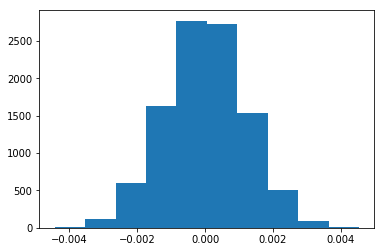

In [111]:
# Plot histogram
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [135]:
diff = treat_prob - cont_prob
(diff < np.array(p_diffs)).mean()

0.90349999999999997

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**
The last value is known as P-value, which is the probability of finding the observed, or more extreme, results when the null hypothesis is true. P-value is used in statistical hypothesis testing to support or reject the null hypothesis. So in our case, p-value (0.9) shows no strong evidence against the null hypothesis. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [143]:
# Import the required library
import statsmodels.api as sm

# Calculate the conversions value

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = n_old
n_new = n_new
print (convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [160]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

print ("z_score = ", z_score, " and ", "p_value: ", p_value)

z_score =  1.31092419842  and  p_value:  0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
Since that z-score indicates how many standard deviations an element is from the mean, which is 1.31 as shown above, and since about 95% of the elements have a z-score between -2 and 2; then yes, it Agree with findings in parts j. and k. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

I will use logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [150]:
# step 0: copy the dataset
df3 = df2.copy()

# step 1: create a column for the intercept
df3['intercept'] = 1

# step 2: create a dummy variable column
df3[['control','treatment']] = pd.get_dummies(df2['group'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [151]:
# step 3: Instantiate the model
logit = sm.Logit(df3['converted'],df3[['intercept' ,'treatment']])

# step 4: fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [154]:
# step 5: summary of the model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jan 2018   Pseudo R-squ.:               8.077e-06
Time:                        18:25:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

- The p-value associated with ab_page is 0.190, which is a little bit higher than the previous p-value, because that in the last one we try to calculate if the probability of the new and the probability of the old are not equal.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**


- It depends on the factors that we would add to build the model, but generally, in machine learning framwork, it is always helpful to reduce the factore if the have same prediction power. It is important when adding new factore to increase the sample size. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [156]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new.head()

,country,timestamp,group,landing_page,converted,intercept
user_id,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1


In [157]:
### Create the necessary dummy variables
df_new[['CA','US']] = pd.get_dummies(df_new['country'])[['CA','US']]

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [158]:
### Fit Your Linear Model And Obtain the Results

# Instantiate the model
logit2 = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'CA']])

# fit the model
result = logit2.fit()

# summary of the model
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jan 2018   Pseudo R-squ.:               1.521e-05
Time:                        21:31:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

Based on the p-values that we produced using different techniques, we can say that there are no strong evidence to reject the null hypothesis.